Author: Omona Emmanuel

**Context**

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

**Attribute Information**

1) ID: unique identifier

2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986

3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)

4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]

6) Sex: M (male) or F (female)

7) Ascites: presence of ascites N (No) or Y (Yes)

8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

9) Spiders: presence of spiders N (No) or Y (Yes)

10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)

11) Bilirubin: serum bilirubin in [mg/dl]

12) Cholesterol: serum cholesterol in [mg/dl]

13) Albumin: albumin in [gm/dl]

14) Copper: urine copper in [ug/day]

15) Alk_Phos: alkaline phosphatase in [U/liter]

16) SGOT: SGOT in [U/ml]

17) Triglycerides: triglicerides in [mg/dl]

18) Platelets: platelets per cubic [ml/1000]

19) Prothrombin: prothrombin time in seconds [s]

20) Stage: histologic stage of disease (1, 2, 3, or 4)

**Acknowledgements**

The dataset can be found in appendix D of:

Fleming, T.R. and Harrington, D.P. (1991) Counting Processes and Survival Analysis. Wiley Series in Probability and Mathematical Statistics: Applied Probability and Statistics, John Wiley and Sons Inc., New York.

fedesoriano. (August 2021). Cirrhosis Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/cirrhosis-prediction-dataset.

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import seaborn as sns
# set display to 100 maximum columns
pd.set_option('display.max_columns',100)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
from sklearn.feature_selection import f_classif, f_regression, VarianceThreshold, SelectFromModel, SequentialFeatureSelector

In [ ]:
# @title UNIVARIATE PLOTTING CUSTOM FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.xaxis.set_major_locator(mticks.MaxNLocator(3))
  ticks_loc = ax.get_xticks().tolist()
  ax.xaxis.set_major_locator(mticks.FixedLocator(ticks_loc))
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show();

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show();


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as number and as percentage
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [ ]:
# @title MULTIVARIATE PLOTTING CUSTOM FUNCTIONS vs. TARGET
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

In [ ]:
# define file path of our dataset
fpath = '/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/cirrhosis.csv'
# read and load dataset with pandas
cir_df = pd.read_csv(fpath)

###### Explore/Clean data

In [ ]:
# obtain the .info and head of the dataframe
display(cir_df.info(),cir_df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

None

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0


In [ ]:
# set ID to index of the dataframe
cir_df.set_index('ID', inplace=True)

# for the 7 object type features we check for consistancy
for item in cir_df.select_dtypes('object').columns:
  print(f'{cir_df[item].value_counts(dropna=False)}')
  print('\n')

Status
C     232
D     161
CL     25
Name: count, dtype: int64


Drug
D-penicillamine    158
Placebo            154
NaN                106
Name: count, dtype: int64


Sex
F    374
M     44
Name: count, dtype: int64


Ascites
N      288
NaN    106
Y       24
Name: count, dtype: int64


Hepatomegaly
Y      160
N      152
NaN    106
Name: count, dtype: int64


Spiders
N      222
NaN    106
Y       90
Name: count, dtype: int64


Edema
N    354
S     44
Y     20
Name: count, dtype: int64




In [ ]:
# check for duplicates
cir_df.duplicated().sum()

0

###### Exploratory Visualizations

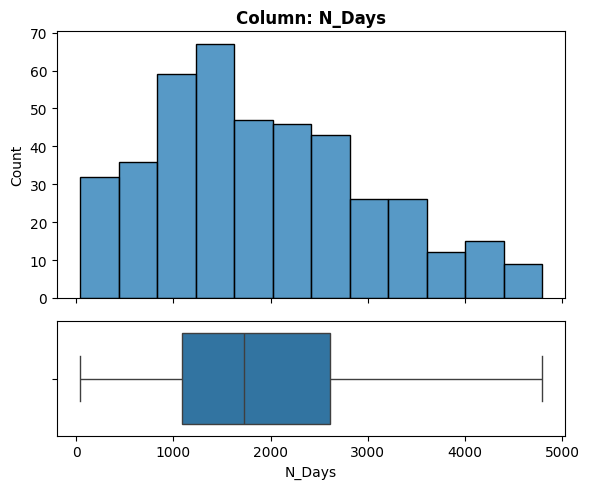

- NaN's Found: 0 (0.0%)
- Unique Values: 399
- Most common value: '1434' occurs 2 times (0.48%)
- Not constant or quasi-constant.

------------------------------------------------------------



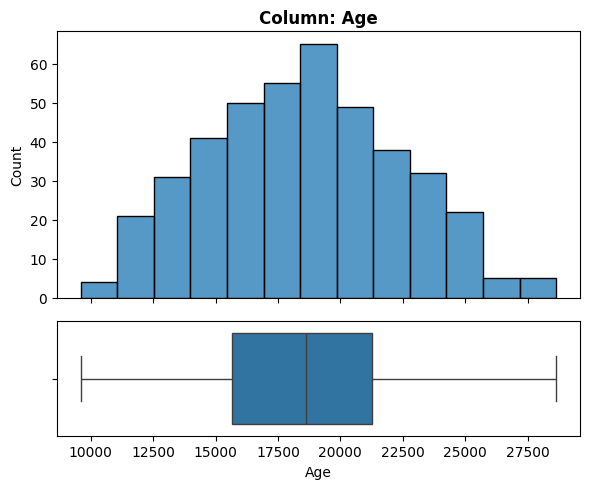

- NaN's Found: 0 (0.0%)
- Unique Values: 344
- Most common value: '19724' occurs 7 times (1.67%)
- Not constant or quasi-constant.

------------------------------------------------------------



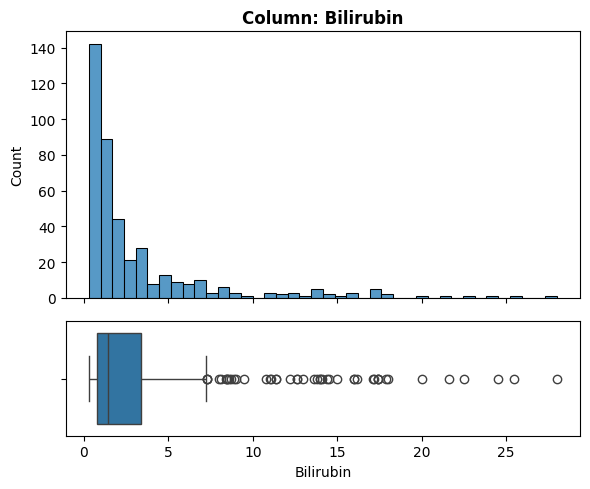

- NaN's Found: 0 (0.0%)
- Unique Values: 98
- Most common value: '0.7' occurs 33 times (7.89%)
- Not constant or quasi-constant.

------------------------------------------------------------



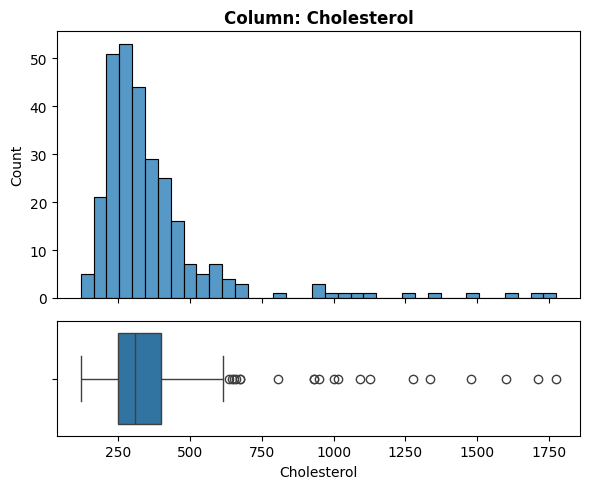

- NaN's Found: 134 (32.06%)
- Unique Values: 201
- Most common value: 'nan' occurs 134 times (32.06%)
- Not constant or quasi-constant.

------------------------------------------------------------



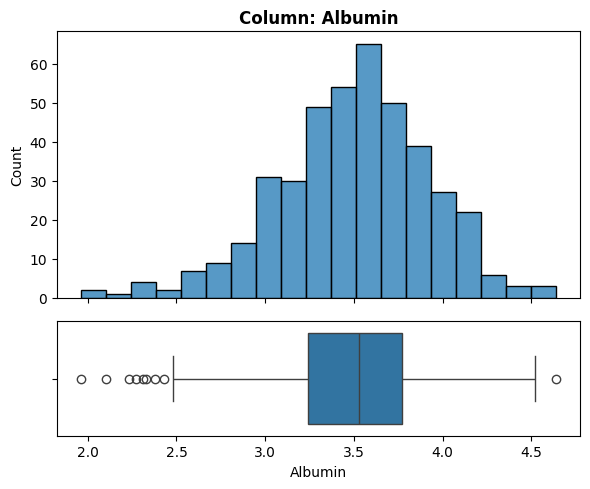

- NaN's Found: 0 (0.0%)
- Unique Values: 154
- Most common value: '3.35' occurs 11 times (2.63%)
- Not constant or quasi-constant.

------------------------------------------------------------



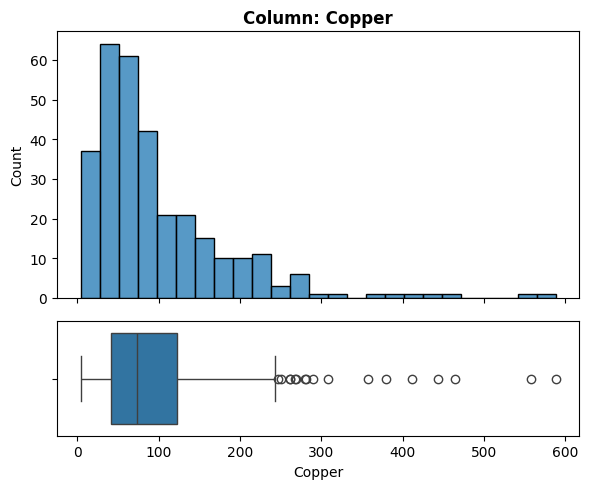

- NaN's Found: 108 (25.84%)
- Unique Values: 158
- Most common value: 'nan' occurs 108 times (25.84%)
- Not constant or quasi-constant.

------------------------------------------------------------



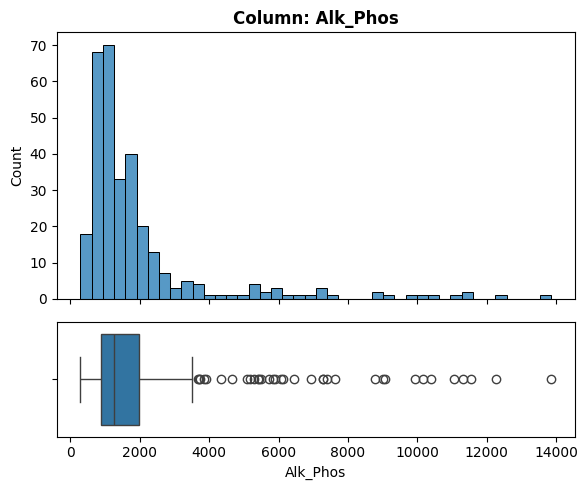

- NaN's Found: 106 (25.36%)
- Unique Values: 295
- Most common value: 'nan' occurs 106 times (25.36%)
- Not constant or quasi-constant.

------------------------------------------------------------



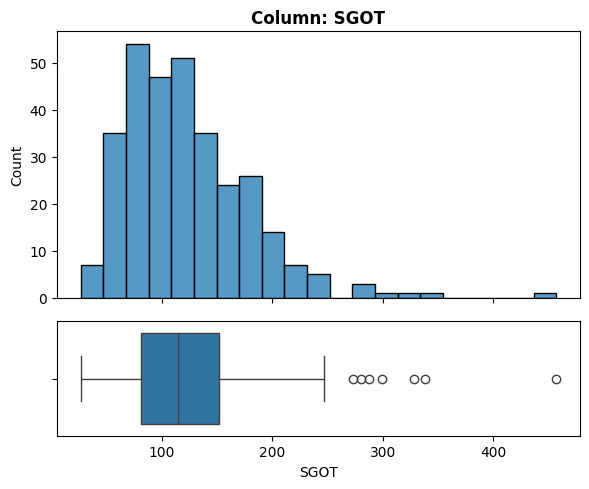

- NaN's Found: 106 (25.36%)
- Unique Values: 179
- Most common value: 'nan' occurs 106 times (25.36%)
- Not constant or quasi-constant.

------------------------------------------------------------



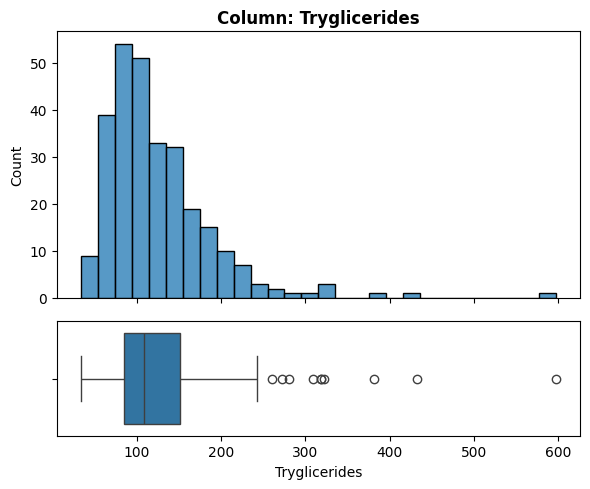

- NaN's Found: 136 (32.54%)
- Unique Values: 146
- Most common value: 'nan' occurs 136 times (32.54%)
- Not constant or quasi-constant.

------------------------------------------------------------



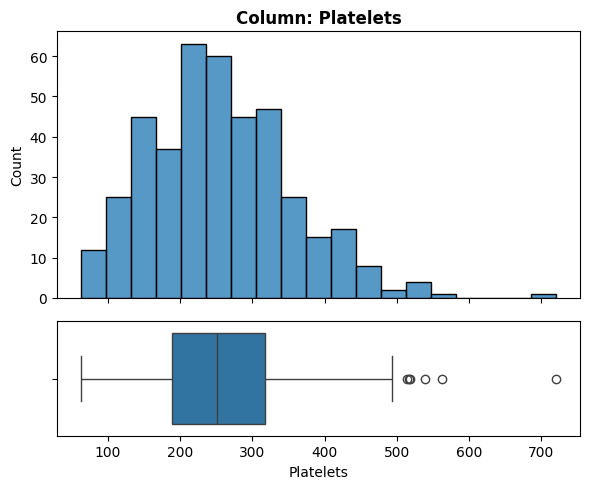

- NaN's Found: 11 (2.63%)
- Unique Values: 243
- Most common value: 'nan' occurs 11 times (2.63%)
- Not constant or quasi-constant.

------------------------------------------------------------



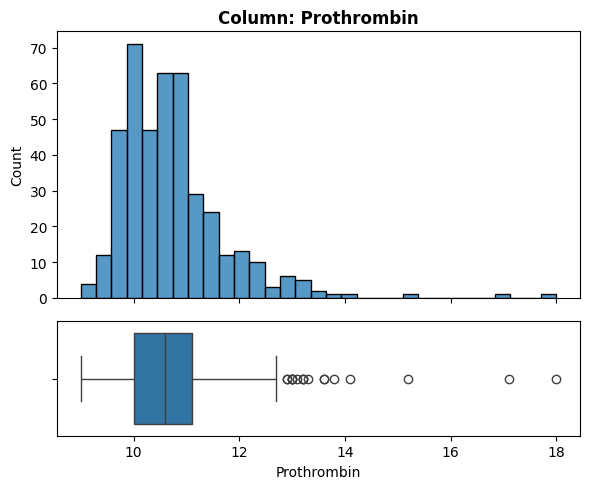

- NaN's Found: 2 (0.48%)
- Unique Values: 48
- Most common value: '10.6' occurs 39 times (9.33%)
- Not constant or quasi-constant.

------------------------------------------------------------



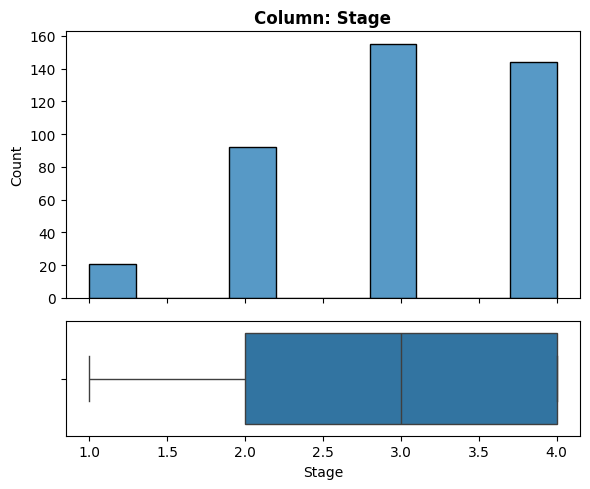

- NaN's Found: 6 (1.44%)
- Unique Values: 4
- Most common value: '3.0' occurs 155 times (37.08%)
- Not constant or quasi-constant.

------------------------------------------------------------



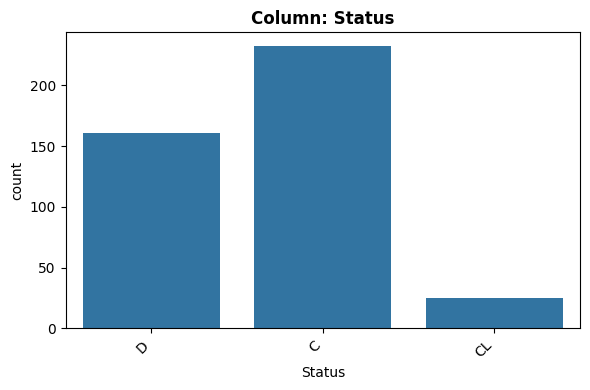

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'C' occurs 232 times (55.5%)
- Not constant or quasi-constant.

------------------------------------------------------------



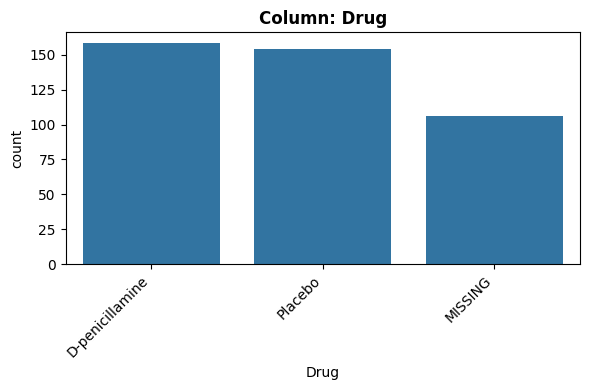

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'D-penicillamine' occurs 158 times (37.8%)
- Not constant or quasi-constant.

------------------------------------------------------------



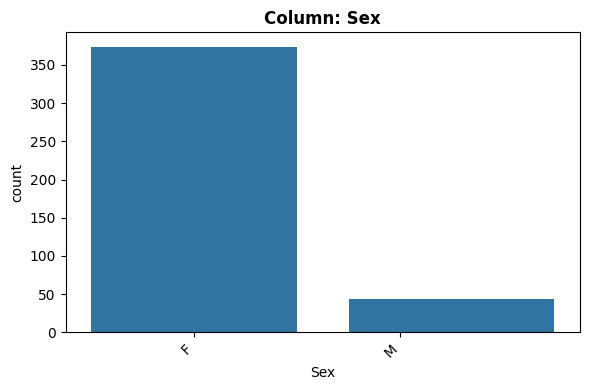

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'F' occurs 374 times (89.47%)
- Not constant or quasi-constant.

------------------------------------------------------------



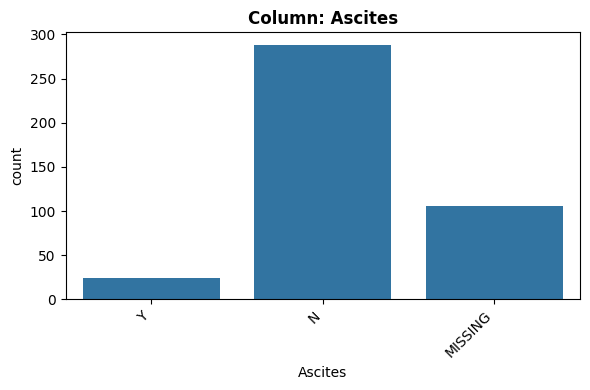

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'N' occurs 288 times (68.9%)
- Not constant or quasi-constant.

------------------------------------------------------------



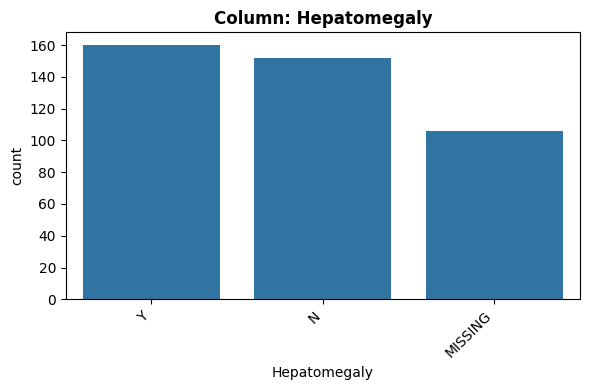

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'Y' occurs 160 times (38.28%)
- Not constant or quasi-constant.

------------------------------------------------------------



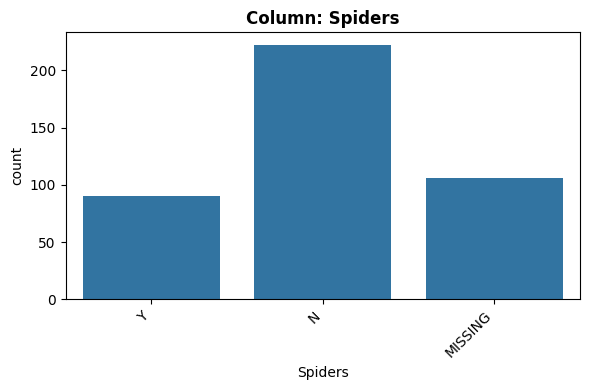

- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Most common value: 'N' occurs 222 times (53.11%)
- Not constant or quasi-constant.

------------------------------------------------------------



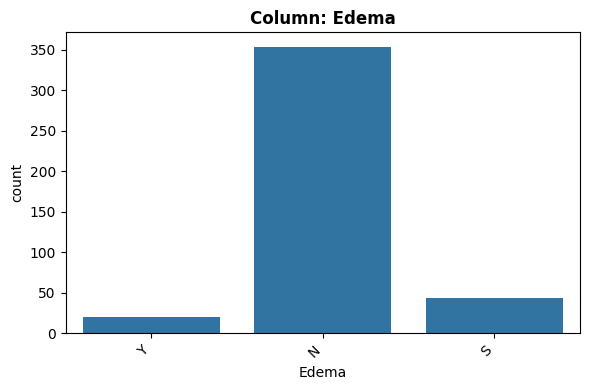

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'N' occurs 354 times (84.69%)
- Not constant or quasi-constant.

------------------------------------------------------------



In [ ]:
## individual viz for all the 19 features (Univariate plots)

# numeric viz
for item in cir_df.select_dtypes('number').columns:
  explore_numeric(df=cir_df, x=item)
  print(f'\n{"--"*30}\n')

# categorical viz
for item in cir_df.select_dtypes('object').columns:
  explore_categorical(df=cir_df, x=item)
  print(f'\n{"--"*30}\n')

- Excluding 134 NaN's
- Excluding 108 NaN's
- Excluding 106 NaN's
- Excluding 106 NaN's
- Excluding 136 NaN's
- Excluding 11 NaN's
- Excluding 2 NaN's
- Excluding 6 NaN's




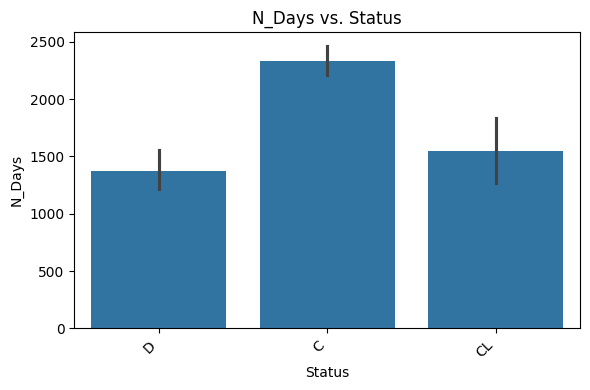

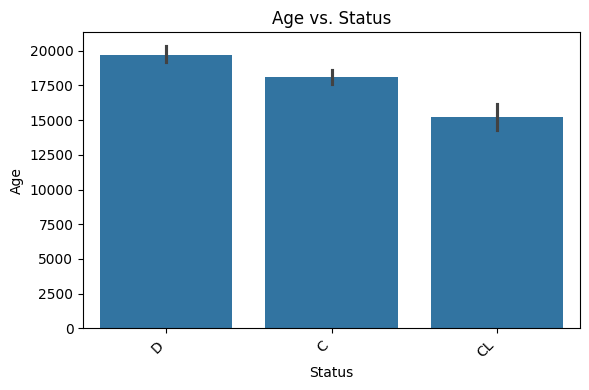

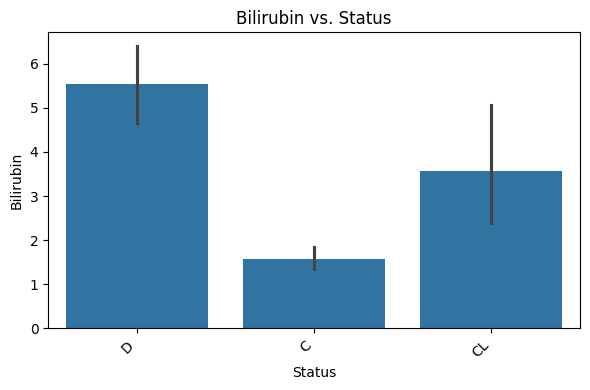

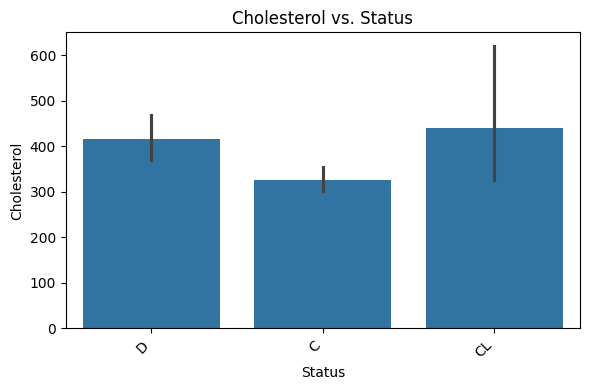

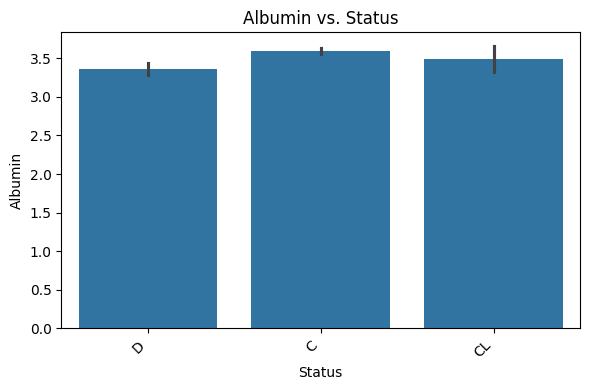

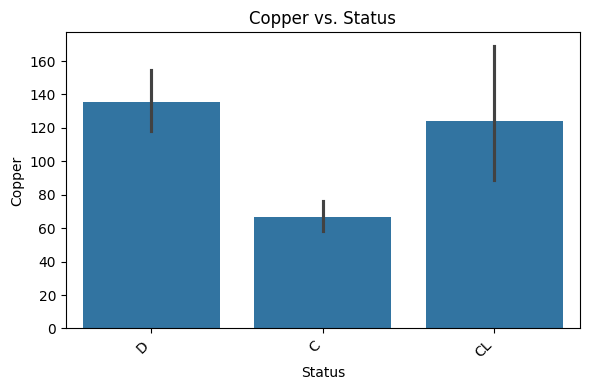

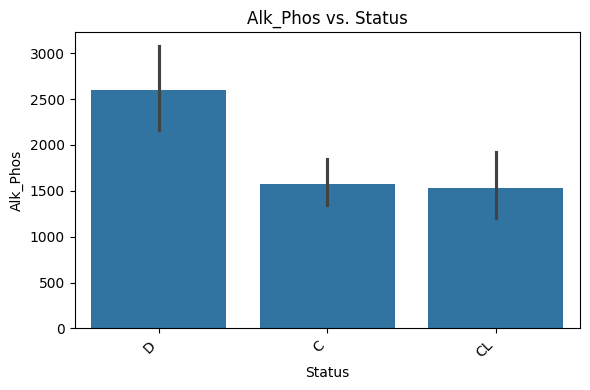

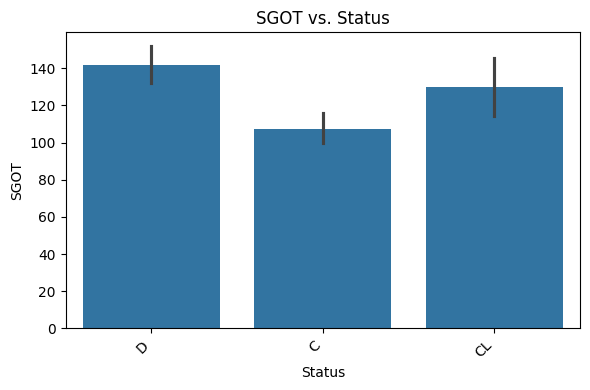

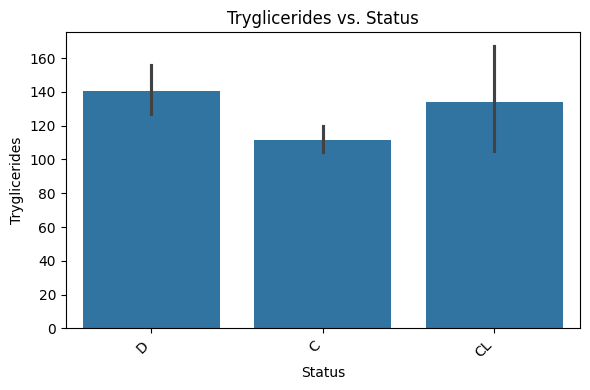

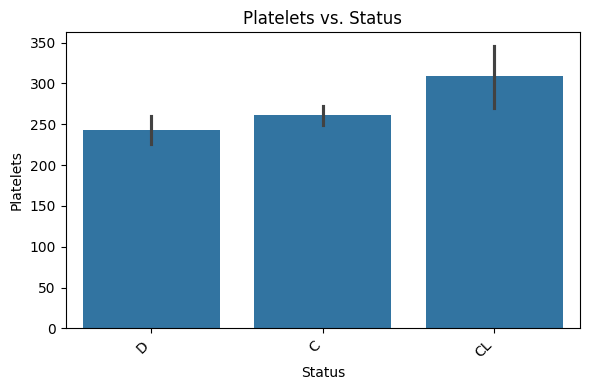

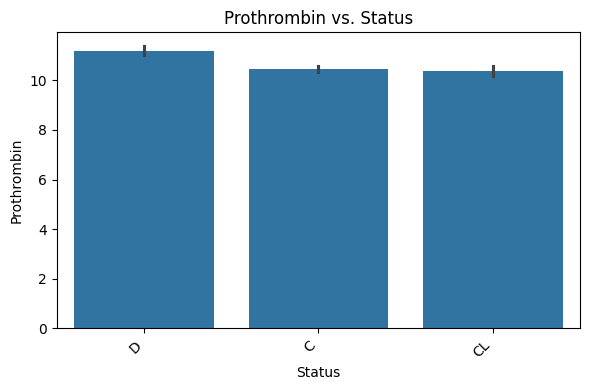

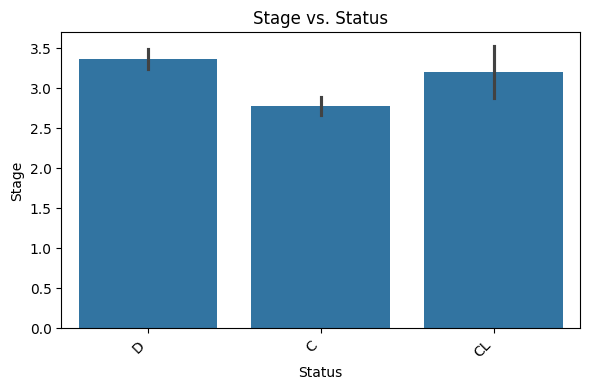

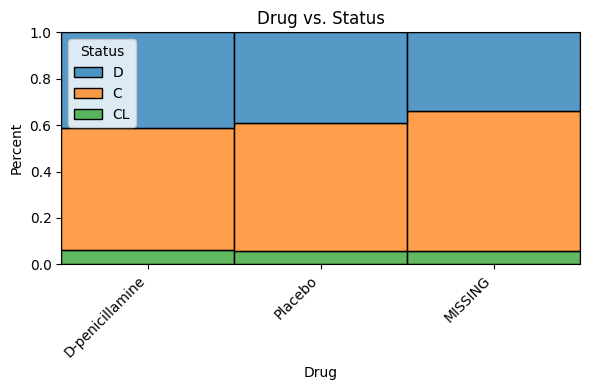

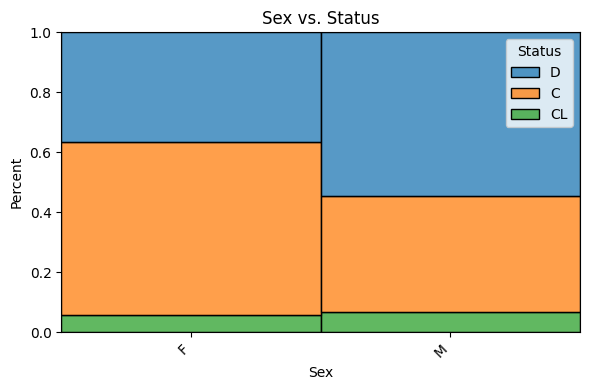

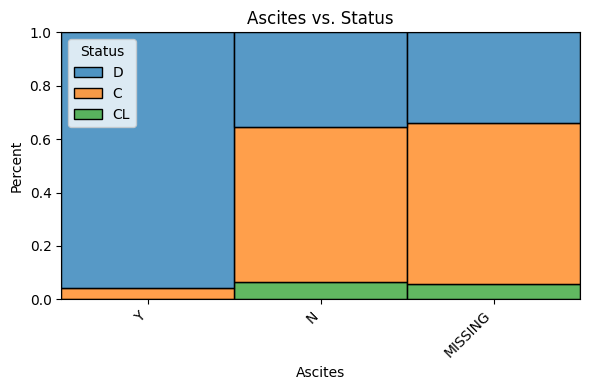

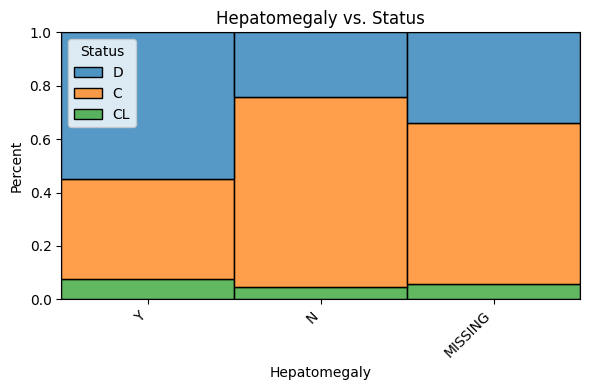

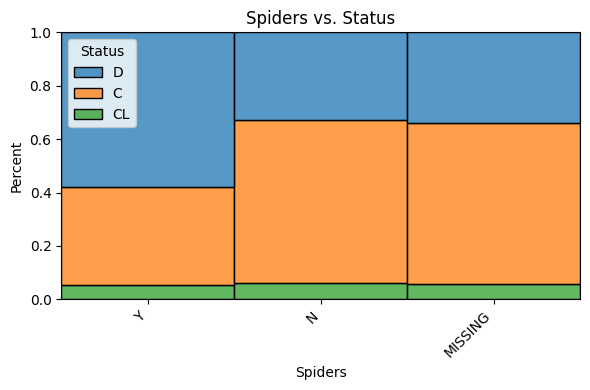

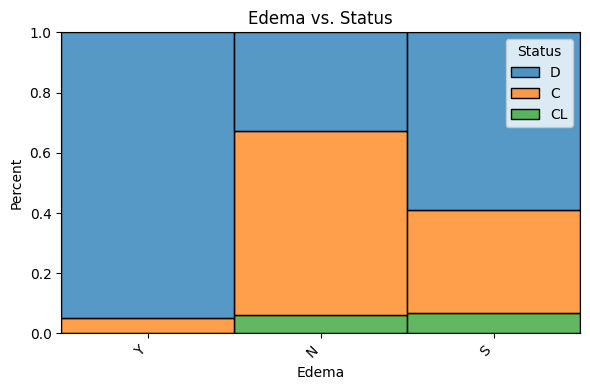

In [ ]:
### possible targets [Stage - numeric, Drug - categorical, Status - categorical]
"""We choose Status"""
target = 'Status'
# we select a copy of dataframe without the chosen target
cir_df_without_target = cir_df.drop(columns=[target]).copy()
### multivariate plots vs target
# numeric viz
for item in cir_df_without_target.select_dtypes('number').columns:
  plot_numeric_vs_target(df=cir_df, x=item, y=target, target_type='class')
print('\n')
# categorical viz
for item in cir_df_without_target.select_dtypes('object').columns:
  plot_categorical_vs_target(df=cir_df, x=item, y=target, target_type='class')

##### MODEL

In [ ]:
# @title train test split
## feature matrice, X and target vector, y
y = cir_df[target]
X = cir_df.drop(columns=[target])
## train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# @title Imbalance check
y_train.value_counts(normalize=True)

Status
C     0.552716
D     0.389776
CL    0.057508
Name: proportion, dtype: float64

In [ ]:
# @title Preprocessing
### None of feature is Ordinal, all features are categorical
"""Therefore we have only Categorical and Numeric Features"""
## categorical feature
cat_cols = X_train.select_dtypes('object').columns
## numeric features
num_cols = X_train.select_dtypes('number').columns

## Feature transformation
# categorical
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
# numeric
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# columns transfomer
preprocessor = ColumnTransformer(transformers=[
    ('numeric', num_trans, num_cols),
    ('categorical', cat_trans, cat_cols)
])

## applying preprocessing
# fit_transform train data
X_train_tf = preprocessor.fit_transform(X_train)
# transform test data
X_test_tf = preprocessor.transform(X_test)

In [ ]:
# @title Balance Data with SMOTE
## instantiate SMOTE
sm = SMOTE(random_state=0)
## fit
X_train_tf_sm, y_train_tf_sm = sm.fit_resample(X_train_tf, y_train)

y_train_tf_sm.value_counts(normalize=True)

Status
C     0.333333
D     0.333333
CL    0.333333
Name: proportion, dtype: float64

In [ ]:
# @title Baseline/Default Model Evalauation
### models to be evaluated
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'k_NN': KNeighborsClassifier()
}
## Evaluation
for k,v in models.items():
  pipe = make_pipeline(v)
  scores = cross_val_score(pipe, X_train_tf_sm, y_train_tf_sm, cv=5, n_jobs=-1)
  print(f'{k}: {scores.mean():.2f} (+/- {scores.std():.2f})')

Logistic Regression: 0.74 (+/- 0.04)
Decision Tree: 0.77 (+/- 0.06)
Random Forest: 0.86 (+/- 0.02)
Gradient Boosting: 0.84 (+/- 0.04)
k_NN: 0.72 (+/- 0.05)


In [ ]:
# @title Hyperparameter Tuning with GridSearchCV
#### logistic regression parameters
# Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
               'logisticregression__penalty' : ['elasticnet'],
                'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000] }
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000]}
# Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
               'logisticregression__penalty' : [None]}
# Now make a list of the param dictionaries
param_grid_lgr = [l2_params, l1_params, elasticnet_params, none_params]

### define parameters
param_grid = {
    'Random Forest': {
        'randomforestclassifier__class_weight': ['balanced'],
        'randomforestclassifier__n_estimators': [25, 50, 100, 150],
        'randomforestclassifier__max_features': ['sqrt', 'log2', None],
        'randomforestclassifier__max_depth': [3, 6, 9],
        'randomforestclassifier__max_leaf_nodes': [3, 6, 9],
    },
    'Gradient Boosting': {
        'gradientboostingclassifier__n_estimators': [100, 200],
        'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'Decision Tree': {
        'decisiontreeclassifier__max_depth': [10, 20, 30, None],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10],
        'decisiontreeclassifier__min_samples_leaf': [1, 2, 4]
    },
    'k_NN': {
        'kneighborsclassifier__n_neighbors' : [5,7,9,11,13,15],
        'kneighborsclassifier__weights' : ['uniform','distance'],
        'kneighborsclassifier__metric' : ['minkowski','euclidean','manhattan']
    },
    'Logistic Regression': param_grid_lgr
}
### tuning with a loop
best_param_model = {}
for k,v in models.items():
  # test for present of key
  if k in param_grid:
    # make pipeline for models
    pipe = make_pipeline(v)
    # instantiate grid search cv
    grid_search = GridSearchCV(pipe, param_grid=param_grid[k], cv=5, n_jobs=-1)
    # fit
    grid_search.fit(X_train_tf_sm, y_train_tf_sm)
    # obtain dict for best param model
    best_param_model[k] = grid_search.best_estimator_
    # print info
    print(f'Best parameters for {k}: {grid_search.best_params_}')
    print(f'Best cross-validation score for {k}: {grid_search.best_score_:.2f}')
    print()

Best parameters for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.74

Best parameters for Decision Tree: {'decisiontreeclassifier__max_depth': 30, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
Best cross-validation score for Decision Tree: 0.79

Best parameters for Random Forest: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_leaf_nodes': 9, 'randomforestclassifier__n_estimators': 100}
Best cross-validation score for Random Forest: 0.77

Best parameters for Gradient Boosting: {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__n_estimators': 200}
Best cross-validation score for Gradient Boosting: 0.86

Best parameters for k_NN: {'kneighborsclassifier__

In [ ]:
# @title CUSTOM EVALUATION FUNC_
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



>>>>>Logistic Regression<<<<<
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.72      0.65      0.68       173
          CL       0.77      0.92      0.84       173
           D       0.83      0.73      0.78       173

    accuracy                           0.77       519
   macro avg       0.77      0.77      0.77       519
weighted avg       0.77      0.77      0.77       519



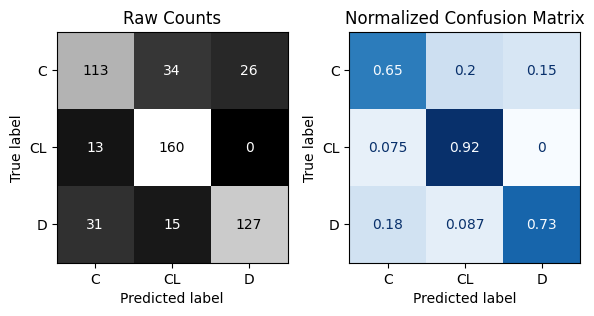


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.73      0.63      0.67        59
          CL       0.09      0.29      0.14         7
           D       0.75      0.62      0.68        39

    accuracy                           0.60       105
   macro avg       0.52      0.51      0.50       105
weighted avg       0.69      0.60      0.64       105



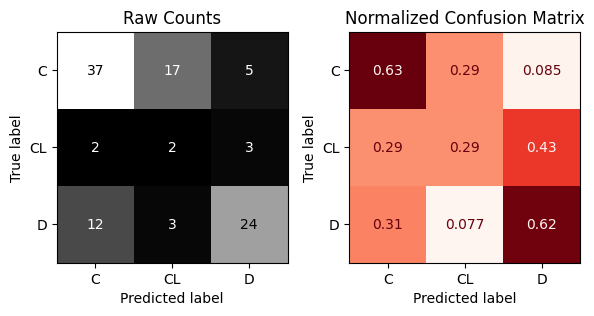


>>>>>Decision Tree<<<<<
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       173
          CL       1.00      1.00      1.00       173
           D       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



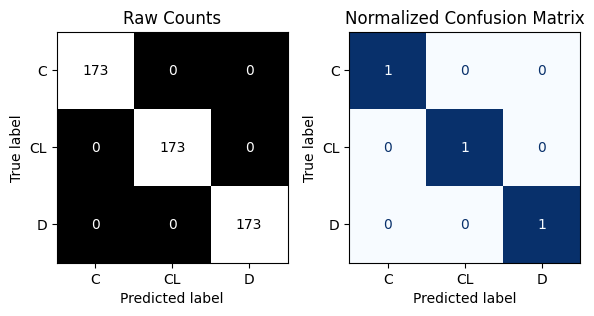


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.66      0.59      0.62        59
          CL       0.00      0.00      0.00         7
           D       0.52      0.56      0.54        39

    accuracy                           0.54       105
   macro avg       0.39      0.39      0.39       105
weighted avg       0.57      0.54      0.55       105



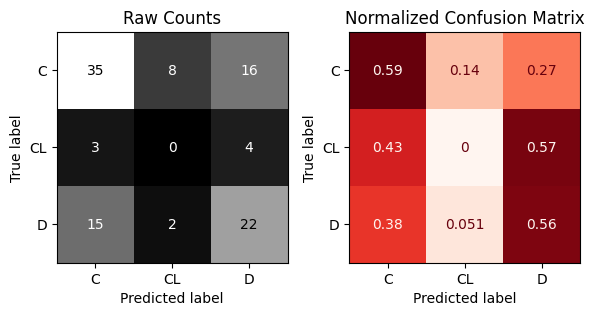


>>>>>Random Forest<<<<<
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.80      0.83      0.81       173
          CL       0.89      0.88      0.89       173
           D       0.84      0.83      0.83       173

    accuracy                           0.84       519
   macro avg       0.84      0.84      0.84       519
weighted avg       0.84      0.84      0.84       519



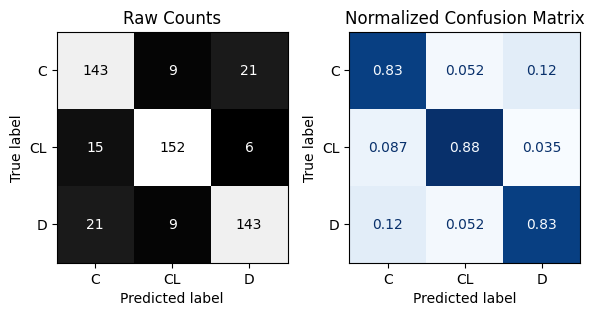


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.77      0.81      0.79        59
          CL       0.00      0.00      0.00         7
           D       0.71      0.62      0.66        39

    accuracy                           0.69       105
   macro avg       0.49      0.48      0.48       105
weighted avg       0.70      0.69      0.69       105



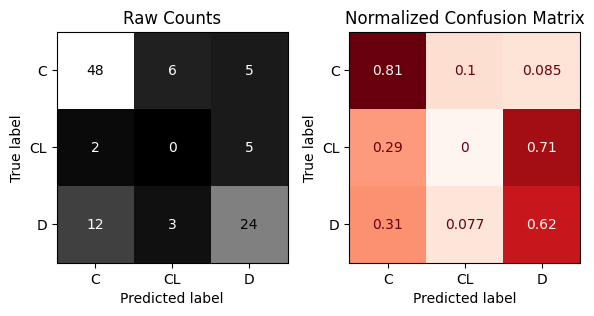


>>>>>Gradient Boosting<<<<<
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       173
          CL       1.00      1.00      1.00       173
           D       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



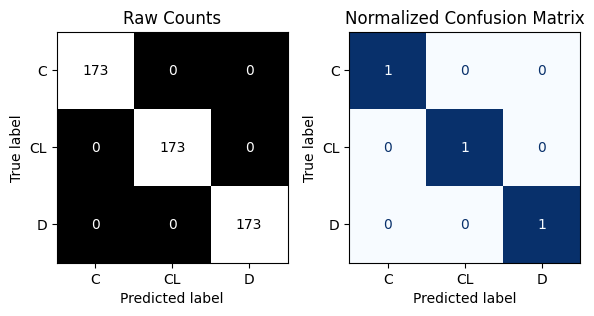


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.79      0.78      0.79        59
          CL       0.00      0.00      0.00         7
           D       0.68      0.72      0.70        39

    accuracy                           0.70       105
   macro avg       0.49      0.50      0.50       105
weighted avg       0.70      0.70      0.70       105



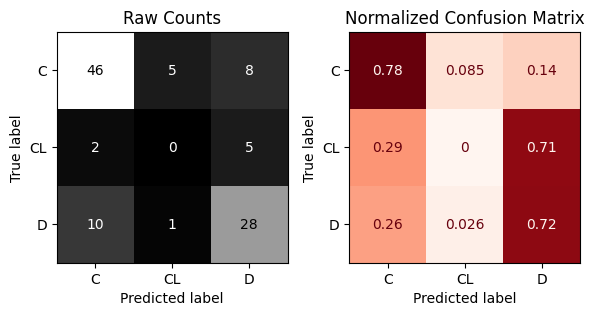


>>>>>k_NN<<<<<
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       173
          CL       1.00      1.00      1.00       173
           D       1.00      1.00      1.00       173

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



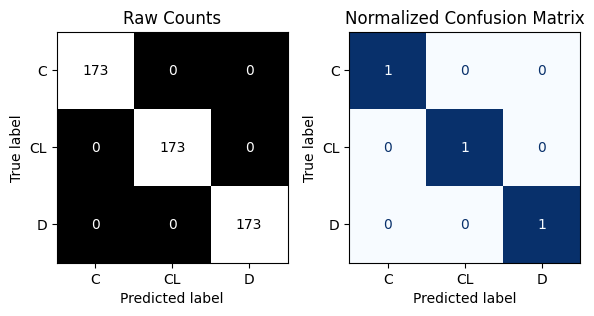


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.75      0.76      0.76        59
          CL       0.13      0.29      0.18         7
           D       0.73      0.56      0.64        39

    accuracy                           0.66       105
   macro avg       0.54      0.54      0.53       105
weighted avg       0.70      0.66      0.67       105



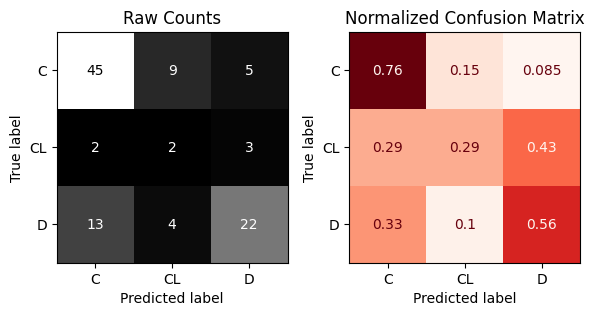

In [ ]:
# @title Model Comparison on Test Data
### loop for best model
for k,v in best_param_model.items():
  print(f'>>>>>{k}<<<<<')
  evaluate_classification(v, X_train_tf_sm, y_train_tf_sm, X_test_tf, y_test)
  print()

Classifier Class: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Classifier Instance: GradientBoostingClassifier(learning_rate=0.2, n_estimators=200)



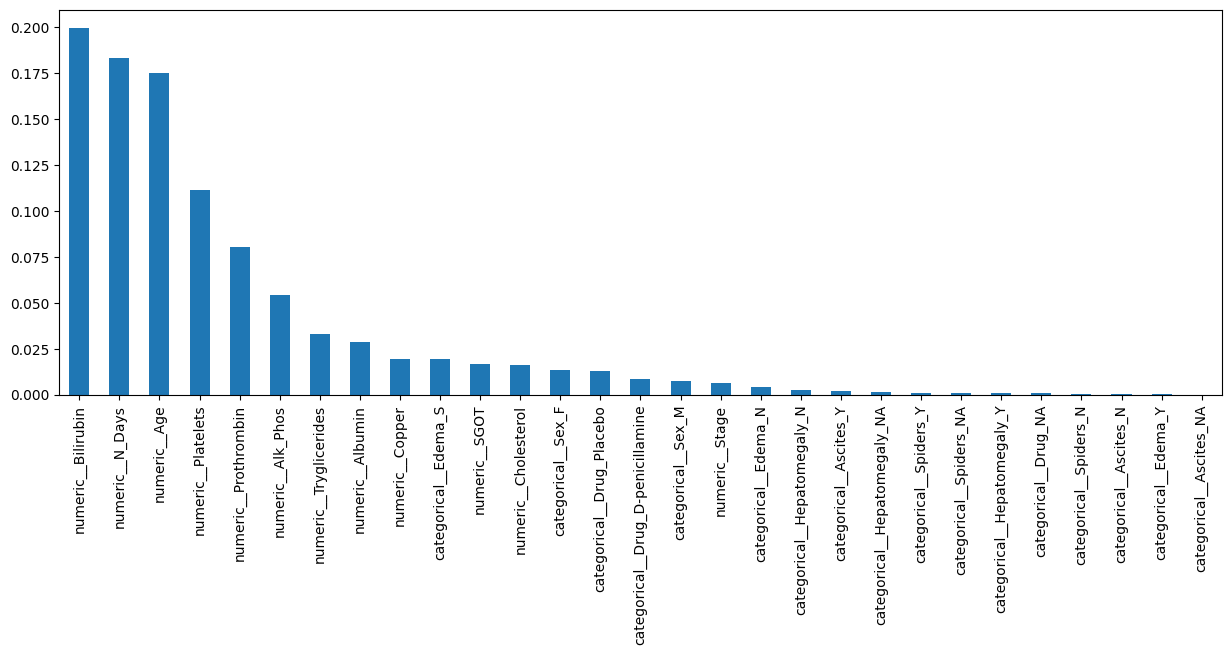

In [ ]:
# @title Feature Importance Bar chart for Best Model
"""We see GradientBoostingClassifier performing best than all others"""
# we define our best gradient boosting classifier parameter
gb_best_param = {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__n_estimators': 200}

# Access the steps of the pipeline
steps = best_param_model['Gradient Boosting'].steps

# Identify and extract the GradientBoostingClassifier
step_name = 'gradientboostingclassifier'
classifier_instance_gbc = dict(steps)[step_name]
classifier_class_gbc = type(classifier_instance_gbc)

# Print the class and instance
print("Classifier Class:", classifier_class_gbc)
print("Classifier Instance:", classifier_instance_gbc)
print()

# fit the best GradientBoostingClassifier param
classifier_instance_gbc.fit(X_train_tf_sm, y_train_tf_sm)

# Access the feature importances of the best estimator
feature_importances = classifier_instance_gbc.feature_importances_

# Create a Pandas Series with feature names and importances
feature_importance_df = pd.Series(feature_importances,
                                 index=classifier_instance_gbc.feature_names_in_)

# Sort the DataFrame by importance and plot a bar chart
feature_importance_df.sort_values(ascending=False).plot.bar(figsize=(15, 5));

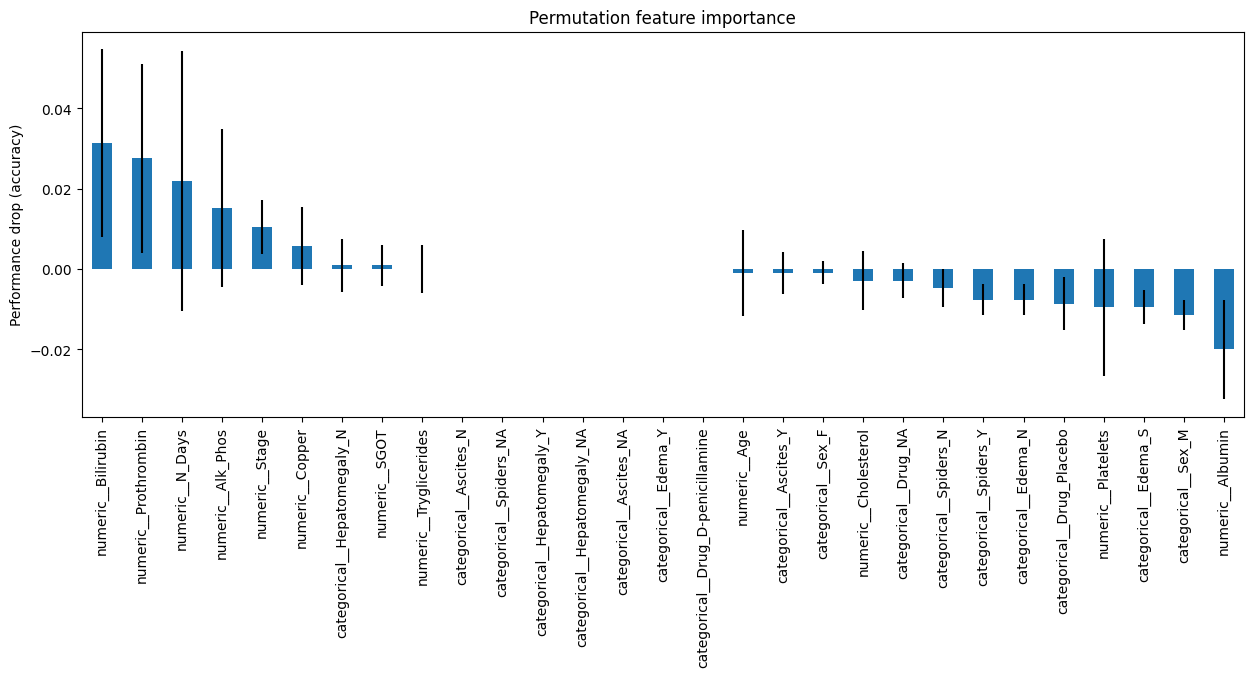

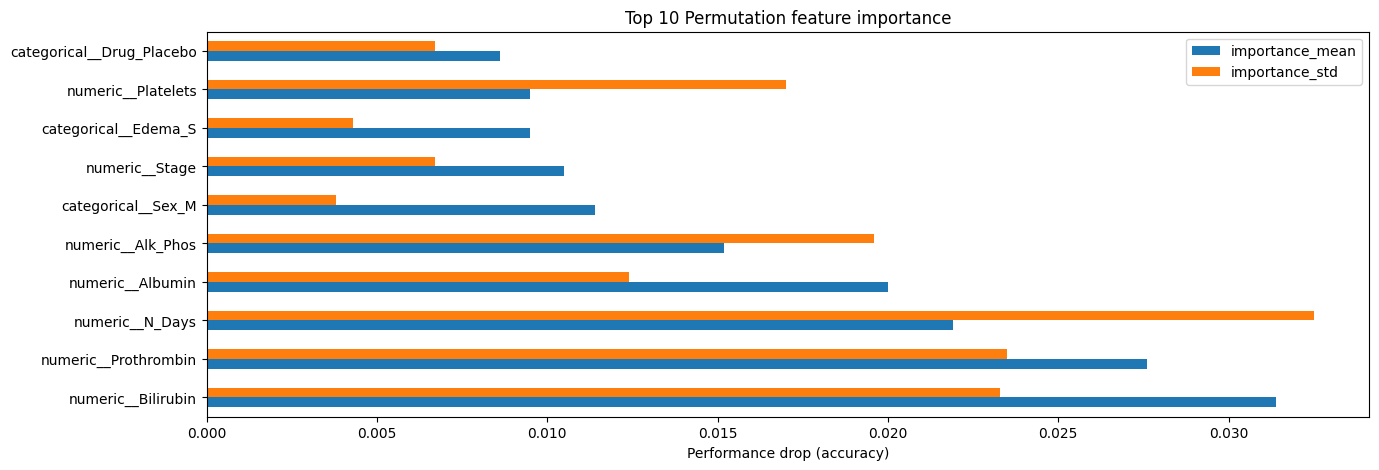

In [ ]:
# @title Feature Importance - Permutation
"""We see Gradient Boosting performing best than other models"""
## compute permutation importance
perm_imp = permutation_importance(classifier_instance_gbc, X_test_tf, y_test, n_repeats=10, random_state=0, n_jobs=-1, scoring='accuracy')

# get importance
importance = pd.DataFrame(
    {"importance_mean": perm_imp["importances_mean"],
     "importance_std": perm_imp["importances_std"]},
    index=classifier_instance_gbc.feature_names_in_)

##### VISUALIZATION
## plot features importance
importance["importance_mean"].sort_values(
    ascending=False
).plot(figsize=(15, 5), kind="bar", yerr=importance["importance_std"])
plt.title("Permutation feature importance")
plt.ylabel("Performance drop (accuracy)")
plt.show();

## plot for top 10 absolute features importance
ab_imp = np.absolute(importance)
ab_imp.sort_values(ascending=False, by='importance_mean').round(4)[:10].plot(figsize=(15, 5), kind="barh")
plt.title("Top 10 Permutation feature importance")
plt.xlabel("Performance drop (accuracy)")
plt.show();

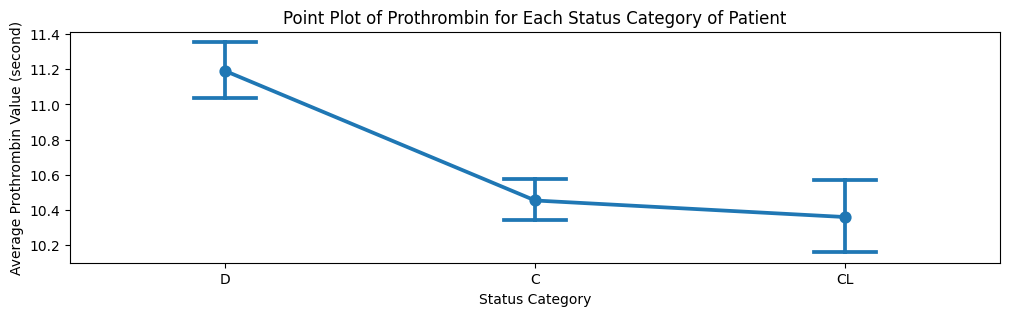

This point plot illustrates the average value of Prothrombin across different Status categories, 
providing insights into the relationship between the feature and the target.



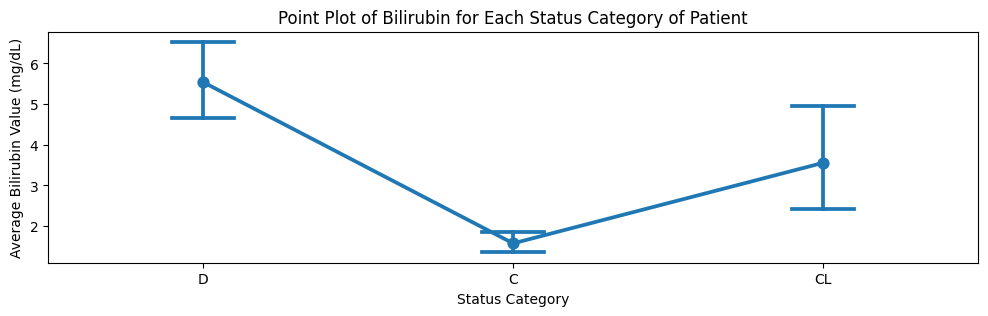

This point plot illustrates the average value of Bilirubin across different Status categories, 
providing insights into the relationship between the feature and the target.


In [ ]:
# @title Visualizing Two of the Top 10 Features Importance
### define the two features
feature_1 = 'Prothrombin'
feature_2 = 'Bilirubin'

### VISUALIZATION
## feature 1
# Create a point chart for feature_1 distribution for each category
plt.figure(figsize=(12, 3))
sns.pointplot(x=target, y=feature_1, data=cir_df, capsize=.2)

# Adding title and labels
plt.title(f'Point Plot of {feature_1} for Each {target} Category of Patient')
plt.xlabel(f'{target} Category')
plt.ylabel(f'Average {feature_1} Value (second)')
plt.show();
print(f'''This point plot illustrates the average value of {feature_1} across different {target} categories,
providing insights into the relationship between the feature and the target.''')
print()

## feature 2
# Create a point chart for feature_2 distribution for each category
plt.figure(figsize=(12, 3))
sns.pointplot(x=target, y=feature_2, data=cir_df, capsize=.2)

# Adding title and labels
plt.title(f'Point Plot of {feature_2} for Each {target} Category of Patient')
plt.xlabel(f'{target} Category')
plt.ylabel(f'Average {feature_2} Value (mg/dL)')
plt.show();
print(f'''This point plot illustrates the average value of {feature_2} across different {target} categories,
providing insights into the relationship between the feature and the target.''')

- **Prothrombin Plot**:
  - This chart shows how long it takes for blood to clot in patients from different Status categories.
  - Each spread represents a group of patients. We're comparing these groups to see if their blood clotting times are different.
  - If a spread are generally higher, it means those patients have longer clotting times.

- **Bilirubin Plot**:
  - This chart measures a liver-produced substance in the blood for different patient groups.
  - Spreads here also represent different patient groups, just like in the first chart.
  - Higher points for a spread mean that group has higher Bilirubin levels.

**Overall Explanation**: These charts help us spot if there are any patterns in blood clotting times or Bilirubin levels among different patient groups. The points and their spread give us a quick snapshot of the health trends we're looking at.